In [1]:
from google.colab import drive
import os

drive.mount('/content/GoogleDrive', force_remount=True)
path = '/content/GoogleDrive/My Drive/vietnamese-nom-script/Text recognition'
os.chdir(path)
!ls

Mounted at /content/GoogleDrive
cnn.py		ctc.py		     kfold.py	     visualizer.py
CRNN		custom_callbacks.py  __pycache__     大越史記全書.jpg
CRNNxAttention	dataset_handler.py   TransformerOCR


In [2]:
# Move dataset to /tmp cause reading files from Drive is very slow
!cp ../Dataset/trdg.zip /tmp
!unzip -q /tmp/trdg.zip -d /tmp

In [2]:
# https://www.tensorflow.org/tutorials/text/image_captioning
# https://www.kaggle.com/code/dschettler8845/bms-image-captioning-w-attention-train
# https://github.com/vuducnghia/attention-ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


# Data input pipeline

In [5]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'/tmp/trdg'
LABELS_PATH = r'/tmp/trdg/labels.txt'
FONT_PATH = r'../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters

In [6]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, min_length=6)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=2)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs)

Number of images found: 4333
Number of labels found: 4333
Number of unique characters: 2347
Characters present: {'㐌': 387, '浪': 356, '朱': 296, '\U000f070b': 292, '𠊛': 262, '\U000f047c': 260, '尼': 256, '娘': 252, '𦋦': 248, '𢚸': 246, '吏': 236, '固': 231, '拱': 220, '之': 199, '埃': 195, '情': 194, '𠳒': 179, '買': 178, '群': 175, '芇': 173, '𠓨': 157, '欺': 154, '別': 149, '麻': 148, '花': 147, '𠬠': 146, '𧗱': 144, '爫': 143, '仙': 142, '𡗶': 138, '𠄩': 132, '塘': 129, '如': 127, '𦖑': 126, '浽': 123, '𠫾': 122, '命': 122, '時': 121, '渚': 120, '渃': 118, '饒': 116, '呐': 115, '払': 115, '強': 114, '分': 114, '傷': 109, '𡢐': 108, '些': 108, '冲': 107, '鐄': 106, '𫽄': 106, '𢬣': 104, '低': 104, '生': 102, '皮': 100, '於': 100, '𧡊': 99, '仍': 99, '身': 98, '咍': 98, '茹': 97, '庒': 95, '牢': 94, '𣈜': 94, '昆': 93, '調': 92, '沛': 89, '\U000f061a': 89, '緣': 88, '細': 87, '公': 86, '月': 85, '油': 84, '﨤': 84, '戈': 84, '典': 84, '爲': 83, '排': 81, '畧': 80, '催': 78, '㗂': 77, '包': 76, '碎': 75, '𠁀': 75, '\U000f02c7': 74, '貝': 70, '賒': 70, '𢪀': 69, '共'

## Visualize the data

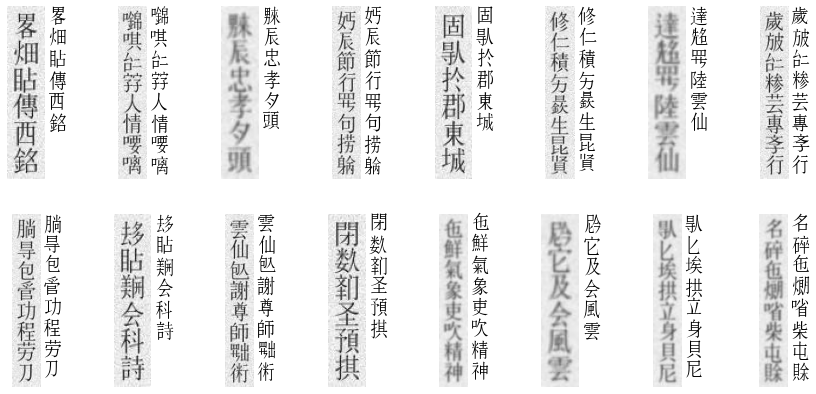

In [7]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [8]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs) + ['[START]', '[END]'], 
    mask_token = '[PAD]',
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = '[PAD]', 
    invert = True,
)

## Prepare `tf.data.Dataset` objects 

In [9]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels]) + 2 # For [START] and [END] tokens
PADDING_TOKEN = char2num('[PAD]')
BATCH_SIZE = 16 
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
def process_image_label(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = tf.strings.unicode_split(label, input_encoding='UTF-8')
    label = char2num(tf.concat([['[START]'], label, ['[END]']], 0))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label}

In [11]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_image_label, num_parallel_calls=AUTOTUNE
    )
    return dataset.repeat().batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

# Define the model

In [12]:
from tensorflow.keras.layers import Input, Embedding, Dense, GRU
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
EMBEDDING_DIM = 512
UNITS = 512

In [13]:
imagenet_model, imagenet_output_layer = None, None
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

## The encoder

In [14]:
def CNN_Encoder(imagenet_model=None, imagenet_output_layer=None, name='CNN_encoder'):
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
    return tf.keras.Model(
        inputs = image_input, 
        outputs = reshape_for_cnn(x, dim_to_keep=-1), 
        name = name
    )

## The attention head

In [15]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, name='BahdanauAttention'):
        super(BahdanauAttention, self).__init__(name=name)
        self.W1 = Dense(UNITS)
        self.W2 = Dense(UNITS)
        self.V = Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 17, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 17, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, 17, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 17, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

## The decoder

In [16]:
def RNN_Decoder(enc_output_shape, vocab_size, name='RNN_Decoder'):
    token_input = Input(shape=(1,), name='new_token')
    features_input = Input(shape=enc_output_shape, name='encoder_output')
    pre_hidden_input = Input(shape=(UNITS,), name='pre_hidden_state')
    
    # Defining attention as a separate model
    attention = BahdanauAttention()
    context_vector, attention_weights = attention(features_input, pre_hidden_input)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    # If mask_zero = True, index 0 cannot be used in the vocabulary,
    # (input_dim should equal size of vocabulary + 1)
    x = Embedding(vocab_size + 1, EMBEDDING_DIM, mask_zero=True)(token_input)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # Passing the concatenated vector to the GRU
    rnn_output, state = GRU(
        units = UNITS, 
        return_state = True, 
        return_sequences = True, 
        recurrent_initializer = 'glorot_uniform',
    )(x, initial_state=pre_hidden_input)

    # shape == (batch_size, max_length, hidden_size)
    x = Dense(UNITS, name='dense')(rnn_output)
    
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # output shape == (batch_size * max_length, vocab)
    y_pred = Dense(vocab_size, name='prediction')(x)

    return tf.keras.Model(
        inputs = [token_input, features_input, pre_hidden_input], 
        outputs = [y_pred, state, attention_weights],
        name = name
    )

## Loss function and the Attention CRNN model 

In [17]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss_func = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss(y_true, y_pred):
    loss = loss_func(y_true, y_pred)
    mask = tf.math.logical_not(tf.math.equal(y_true, PADDING_TOKEN))
    mask = tf.cast(mask, dtype=loss.dtype)
    
    # The PADDING_TOKEN need to be 0 for SparseCategoricalCrossentropy
    # See https://stackoverflow.com/questions/63171001 if loss == nan
    return tf.reduce_mean(loss * mask)

In [39]:
class AttentionCRNN(tf.keras.Model):
    def __init__(self, name='AttentionCRNN'):
        super(AttentionCRNN, self).__init__(name=name)
        self.encoder = CNN_Encoder(imagenet_model, imagenet_output_layer)
        self.decoder = RNN_Decoder(
            self.encoder.output_shape[1:], 
            char2num.vocabulary_size()
        )
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    @tf.function
    def _compute_loss(self, batch):
        dec_input = tf.expand_dims([char2num('[START]')] * BATCH_SIZE, 1) 
        hidden = tf.zeros((BATCH_SIZE, UNITS), tf.float32)
        
        batch_images, batch_labels = batch['image'], batch['label']
        features = self.encoder(batch_images)
        loss = 0
        
        for i in range(1, MAX_LENGTH):
            # Passing the features through the decoder
            preds, hidden, _ = self.decoder([dec_input, features, hidden])
            loss += masked_loss(batch_labels[:, i], preds)

            # Use teacher forcing
            dec_input = tf.expand_dims(batch_labels[:, i], 1) 
        return loss, loss / MAX_LENGTH 

    @tf.function
    def train_step(self, batch):
        with tf.GradientTape() as tape:
            loss, average_loss = self._compute_loss(batch)
            
        # Apply an optimization step
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': average_loss}
    
    @tf.function
    def test_step(self, batch):
        loss, average_loss = self._compute_loss(batch)
        return {'loss': average_loss}
    
    @tf.function
    def predict(model, batch_images):
        batch_size = batch_images.shape[0]
        start_ids = [char2num('[START]')] * batch_size
        result = [start_ids]

        dec_input = tf.expand_dims(start_ids, 1) 
        hidden = tf.zeros((batch_size, UNITS), tf.float32)
        features = model.encoder(batch_images)

        for i in range(1, MAX_LENGTH):
            preds, hidden, _ = model.decoder([dec_input, features, hidden])
            pred_ids = tf.math.argmax(preds, 1)
            dec_input = pred_ids
            result.append(dec_input)
        return tf.transpose(result)

In [40]:
model = AttentionCRNN()
model.encoder.summary(line_length=93)
print()
model.decoder.summary(line_length=125)

Model: "CNN_encoder"
_____________________________________________________________________________________________
 Layer (type)                            Output Shape                          Param #       
 image (InputLayer)                      [(None, 148, 32, 1)]                  0             
                                                                                             
 block1_conv1 (Conv2D)                   (None, 148, 32, 64)                   640           
                                                                                             
 block1_bn1 (BatchNormalization)         (None, 148, 32, 64)                   256           
                                                                                             
 block1_activation1 (LeakyReLU)          (None, 148, 32, 64)                   0             
                                                                                             
 block1_pool (MaxPooling2D)            

# Training

## Callbacks

In [41]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

def scheduler(epoch, lr):
    if epoch < 1 or (epoch % 5) > 0: return lr # Keeps lr for each 5 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    min_lr = 1e-7, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

In [42]:
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
stuck_str = 'val_loss - loss >= 10 or (epoch > 5 and val_loss > 30)'
early_stopping_callback = EarlyStoppingWithStuck(patience=5, stuck_str=stuck_str)

## Cross validation with K-Fold

In [43]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 3

In [44]:
@kfold_decorator(n_splits=10, random_state=2022, is_subclassed_model=True)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    validation_steps = len(valid_idx) // BATCH_SIZE

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(
        model, 
        valid_tf_dataset.take(validation_steps), 
        MAX_LENGTH
    )
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        validation_steps = validation_steps,
        steps_per_epoch = len(train_idx) // BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
        model
    )

In [45]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

============== Fold 01 training ==============
Epoch 1/3
243/243 [==============================] - 59s 186ms/step - loss: 5.0759 - val_loss: 4.8693 - lr: 2.0000e-04
Epoch 2/3
 86/243 [=========>....................] - ETA: 23s - loss: 4.7528

KeyboardInterrupt: ignored

# Evaluation

In [27]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_attention(img_path, result, attention_plot):
    temp_image = np.array(Image.open(img_path))
    result_length = len(result)
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(result_length):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(result_length / 2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
def predict_one_image(model, image):
    dec_input = tf.expand_dims([char2num('[START]')], 0) 
    hidden = tf.zeros((1, UNITS), tf.float32)
    features = model.encoder(image) # Must have batch dimension although just 1 image used
    
    attention_plot = np.zeros((MAX_LENGTH, model.encoder.outputs[0].shape[1]))
    result = []

    for i in range(MAX_LENGTH):
        preds, hidden, attention_weights = model.decoder([dec_input, features, hidden])
        pred_id = tf.random.categorical(preds, 1)[0][0].numpy()
        pred_char = tf.compat.as_text(num2char(pred_id).numpy())
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        if pred_char == '[END]': return result, attention_plot
        dec_input = tf.expand_dims([pred_id], 0)
        result.append(pred_char)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
random_path = '大越史記全書.jpg'
random_label = '大越史記全書'
random_sample = process_image_label(random_path, random_label)
batch_images = tf.expand_dims(random_sample['image'], axis=0)